In [9]:
#This script creates visualizations of empirical coverage and confidence region area for 95 percent approximate confidence regions for exact likelihoood,
#calibrated neural likelihood and uncalibrated neural likelihood.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Polygon as geometry_polygon
from mpl_toolkits.axes_grid1 import ImageGrid

In [10]:
#Load pairwise likelihood surfaces and neural likelihood surfaces (both uncalibrated and calibrated)
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
distance_constraint = 2
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/brown_resnick"
pwlfields2_file = (local_folder + "/evaluate_nn/produce_pairwise_likelihood_surfaces/unadjusted/data/" 
                                     + image_name + "/dist_" + str(distance_constraint) + 
                                  "/single/reps/200/pairwise_likelihood_surfaces_9_by_9_density_" + image_name
                                    + "_image_200.npy")
pwlfields2 = np.load(pwlfields2_file)

distance_constraint = 1
pwlfields1_file = (local_folder + "/evaluate_nn/produce_pairwise_likelihood_surfaces/unadjusted/data/" 
                                     + image_name + "/dist_" + str(distance_constraint) + 
                                  "/single/reps/200/pairwise_likelihood_surfaces_9_by_9_density_" + image_name
                                    + "_image_200.npy")
pwlfields1 = np.load(pwlfields1_file)

version = "final_version"
uncalibrated_fields_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + image_name
                                        + "/" + version + "/uncalibrated/single/reps/200/"
                                        "/uncalibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
uncalibrated_fields = np.load(uncalibrated_fields_file)

calibrated_fields_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                              image_name + "/" + version + "/calibrated/single/reps/200/" +
                                              "calibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
calibrated_fields = np.load(calibrated_fields_file)

number_of_parameters = 81
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_9_by_9_density_" + image_name + "_200.npy"))

possible_ranges = [round(.05*i,2) for i in range(1, 41)]
possible_ranges[39] = 1.99
possible_smooths = [round(.05*i,2) for i in range(1, 41)]
possible_smooths[39] = 1.99
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [20]:
#Compute the empirical coverage of the approximate confidence regions for pairwise likleihood
    #parameters:
        #pairwise_likelihood_surface: 40 by 40 matrix, pairwise likelihood surface for a given realization of the BR
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom
            #(dimension of parameter space)
        #true_range: the range value which generated the realization of the BR
        #true_smooth: the smooth value which generated the realization of the BR
def compute_pairwise_empirical_coverage(pairwise_likelihood_surface, possible_ranges, possible_smooths, C, true_range,
                                        true_smooth):

    max_field_value = np.max(pairwise_likelihood_surface)
    possible_ranges = np.array(possible_ranges)
    possible_smooths = np.array(possible_smooths)
    range_index = (np.where(possible_ranges == true_range))[0]
    smooth_index = (np.where(possible_smooths == true_smooth))[0]
    true_field_value = (pairwise_likelihood_surface[smooth_index, range_index])[0]
    difference = 2*(max_field_value - true_field_value)
    if(difference < 0):
        return "error"
    else:
        return (difference <= C)

#Compute the empirical coverage of the approximate confidence regions for neural likleihood (both calibrated and uncalibrated)
    #parameters:
        #neural_likelihood surface: 40 by 40 matrix, neural likelihood surface (calibrated or uncalibrated) for a given realization
            # of the BR
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
                # (dimension of parameter space)
        #true_range: the range value which generated the realization of the BR
        #true_smooth: the smooth value which generated the realization of the BR  
def compute_neural_empirical_coverage(neural_likelihood_surface, possible_ranges, possible_smooths, C, true_range, true_smooth):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    possible_ranges = np.array(possible_ranges)
    possible_smooths = np.array(possible_smooths)
    range_index = (np.where(possible_ranges == float(true_range)))[0]
    smooth_index = (np.where(possible_smooths == float(true_smooth)))[0]
    true_field_value = np.log((neural_likelihood_surface[smooth_index, range_index])[0])
    difference = 2*(max_field_value - true_field_value)
    if(difference < 0):
        return "error"
    else:
        return (difference <= C)

#Compute the area of the approximate confidence region
def compute_confidence_region_area(confidence_region):

    area = (geometry_polygon(zip(confidence_region[:,0], confidence_region[:,1]))).area
    return area

#compute the 9 by 9 grid over the parameter space which contains the empirical coverage
#in each cell corresponding to that parameter on the parameter grid for pairwise likelihood
    #parameters:
        #pairwise_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the pairwise likelihood
            # surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_empirical_coverage_matrix_for_pairwise_likelihood(pairwise_likelihood_surfaces, number_of_parameters, number_of_reps, 
                                                              possible_ranges, possible_smooths, C, parameter_matrix):

    empirical_coverage_matrix = np.zeros((number_of_parameters, number_of_reps))
    empirical_coverage_visualization_matrix = np.zeros((9, 9))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_range = round(parameter_matrix[ipred, 0], 2)
            current_smooth = round(parameter_matrix[ipred,1], 2)
            current_field = pairwise_likelihood_surfaces[ipred,irep,:,:]
            empirical_coverage_matrix[ipred,irep] = int(compute_pairwise_empirical_coverage(np.transpose(current_field), possible_ranges,
                                                                                            possible_smooths, C, current_range, current_smooth))

        empirical_coverage_visualization_matrix[int(ipred % 9), 
                                                int(ipred / 9)] = (np.sum(empirical_coverage_matrix[ipred,:])/number_of_reps)

    return empirical_coverage_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the empirical coverage
#in each cell corresponding to that parameter on the parameter grid for adjusted pairwise likelihood
    #parameters:
        #adjusted_pairwise_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, 
        # contains all the pairwise likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_empirical_coverage_matrix_for_adjusted_pairwise_likelihood(adjusted_pairwise_likelihood_surfaces,
                                                                       number_of_parameters,
                                                                       number_of_reps, possible_ranges, possible_smooths, C,
                                                                       parameter_matrix):

    empirical_coverage_matrix = np.zeros((number_of_parameters, number_of_reps))
    empirical_coverage_visualization_matrix = np.zeros((9, 9))
    #skip over the three parameters which we could not adjust the surfaces for (55, 64, 73)
    ipreds = ([i for i in range(0, 54)] + [i for i in range(55,63)] + [i for i in range(64,72)] + [i for i in range(73,81)])
    for ipred in ipreds:
        for irep in range(0, number_of_reps):
            current_range = round(parameter_matrix[ipred, 0], 2)
            current_smooth = round(parameter_matrix[ipred,1], 2)
            current_field = adjusted_pairwise_likelihood_surfaces[ipred,irep,:,:]
            empirical_coverage_matrix[ipred,irep] = int(compute_pairwise_empirical_coverage(np.transpose(current_field), possible_ranges,
                                                                                            possible_smooths, C, current_range, current_smooth))

        empirical_coverage_visualization_matrix[int(ipred % 9), 
                                                int(ipred / 9)] = (np.sum(empirical_coverage_matrix[ipred,:])/number_of_reps)

    return empirical_coverage_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the empirical coverage
#in each cell corresponding to that parameter on the parameter grid for neural likelihood (calibrated or uncalibrated)
    #parameters:
        #neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the neural likelihood 
            # surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (100)
        #number_of_reps: number of exact likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_empirical_coverage_matrix_for_neural_likelihood(neural_likelihood_surfaces, number_of_parameters, number_of_reps,
                                                            possible_ranges, possible_smooths, C, parameter_matrix):

    empirical_coverage_matrix = np.zeros((number_of_parameters, number_of_reps))
    empirical_coverage_visualization_matrix = np.zeros((9, 9))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_range = round(parameter_matrix[ipred, 0], 3)
            current_smooth = round(parameter_matrix[ipred,1], 3)
            current_field = neural_likelihood_surfaces[ipred,irep,:,:]
            empirical_coverage_matrix[ipred,irep] = int(compute_neural_empirical_coverage(np.transpose(current_field), possible_ranges,
                                                                                          possible_smooths, C, current_range, current_smooth))

        empirical_coverage_visualization_matrix[int(ipred % 9), 
                                                int(ipred / 9)] = (np.sum(empirical_coverage_matrix[ipred,:])/number_of_reps)

    return empirical_coverage_visualization_matrix

#Produce the approximate confidence region for pairwise likelihood surface given a cut off value C
    #parameters:
        #pairwise_likelihood_surface: 40 by 40 matrix, pairwise likelihood surface for a given realization of the BR
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
def produce_pairwise_likelihood_confidence_region(pairwise_likelihood_surface, possible_ranges, possible_smooths, C):

    max_field_value = np.max(pairwise_likelihood_surface)
    field_difference = 2*(max_field_value - pairwise_likelihood_surface)
    confidence_grid = np.where(field_difference <= C, 1, 0)

    smooth_values = []
    range_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[min_val])

    confidence_region = np.zeros((len(smooth_values),2))
    confidence_region[:,0] = range_values
    confidence_region[:,1] = smooth_values

    return confidence_region

#Produce the approximate confidence region for a neural likelihood surface (calibrated or uncalibrated) given a cut off value C
    #parameters:
        #neural_likelihood_surface: 40 by 40 matrix, neural likelihood surface for a given realization of the BR
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
def produce_neural_likelihood_confidence_region(neural_likelihood_surface, possible_ranges, possible_smooths, C):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
    confidence_grid = np.where(field_difference <= C, 1, 0)

    smooth_values = []
    range_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[min_val])

    confidence_region = np.zeros((len(smooth_values),2))
    confidence_region[:,0] = range_values
    confidence_region[:,1] = smooth_values

    return confidence_region

#compute the 9 by 9 grid over the parameter space which contains the approximate confidence region area
#in each cell corresponding to that parameter on the parameter grid for pairwise likelihood
    #parameters:
        #pairwise_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the pairwise likelihood
            # surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_pairwise_likelihood_confidence_region_area_matrix(pairwise_likelihood_surfaces, number_of_parameters, number_of_reps,
                                                              possible_ranges, possible_smooths, C, parameter_matrix):

    area_matrix = np.zeros((number_of_parameters, number_of_reps))
    area_visualization_matrix = np.zeros((9, 9))
    fig, ax = plt.subplots(figsize = (10,10))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_range = parameter_matrix[ipred,0]
            current_smooth = parameter_matrix[ipred,1]
            current_field = pairwise_likelihood_surfaces[ipred,irep,:,:]
            confidence_region = produce_pairwise_likelihood_confidence_region(current_field, possible_ranges,
                                                                              possible_smooths, C)
            if(confidence_region.shape[0] > 2):
                area_matrix[ipred,irep] = round(compute_confidence_region_area(confidence_region), 3)

        area_visualization_matrix[int(ipred % 9), int(ipred / 9)] = (np.sum(area_matrix[ipred,:])/number_of_reps)

    return area_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the approximate confidence region area
#in each cell corresponding to that parameter on the parameter grid for adjusted pairwise likelihood
    #parameters:
        #adjusted_pairwise_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix,
        # contains all the pairwise likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (100)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_adjusted_pairwise_likelihood_confidence_region_area_matrix(adjusted_pairwise_likelihood_surfaces,
                                                                       number_of_parameters, number_of_reps,
                                                                       possible_ranges, possible_smooths, C,
                                                                       parameter_matrix):

    area_matrix = np.zeros((number_of_parameters, number_of_reps))
    area_visualization_matrix = np.zeros((9, 9))
    fig, ax = plt.subplots(figsize = (10,10))

    ipreds = ([i for i in range(0, 54)] + [i for i in range(55,63)] + [i for i in range(64,72)] + [i for i in range(73,81)])
    for ipred in ipreds:
        for irep in range(0, number_of_reps):
            current_range = parameter_matrix[ipred,0]
            current_smooth = parameter_matrix[ipred,1]
            current_field = adjusted_pairwise_likelihood_surfaces[ipred,irep,:,:]
            confidence_region = produce_pairwise_likelihood_confidence_region(current_field, possible_ranges, possible_smooths, C)
            if(confidence_region.shape[0] > 2):
                area_matrix[ipred,irep] = round(compute_confidence_region_area(confidence_region), 3)

        area_visualization_matrix[int(ipred % 9), int(ipred / 9)] = (np.sum(area_matrix[ipred,:])/number_of_reps)

    return area_visualization_matrix

#compute the 9 by 9 grid over the parameter space which contains the approximate confidence region area
#in each cell corresponding to that parameter on the parameter grid for neural likelihood (calibrated or uncalibrated)
    #parameters:
        #neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, 
            # contains all the neural likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (100)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def compute_neural_likelihood_confidence_region_area_matrix(neural_likelihood_surfaces, number_of_parameters, number_of_reps,
                                                            possible_ranges, possible_smooths, C, parameter_matrix):

    area_matrix = np.zeros((number_of_parameters, number_of_reps))
    area_visualization_matrix = np.zeros((9, 9))
    fig, ax = plt.subplots(figsize = (10,10))

    for ipred in range(0, number_of_parameters):
        for irep in range(0, number_of_reps):
            current_field = neural_likelihood_surfaces[ipred,irep,:,:]
            confidence_region = produce_neural_likelihood_confidence_region(current_field, possible_ranges, 
                                                                            possible_smooths, C)
            if(confidence_region.shape[0] > 2):
                area_matrix[ipred,irep] = round(compute_confidence_region_area(confidence_region), 3)

        area_visualization_matrix[int(ipred % 9), int(ipred / 9)] = (np.sum(area_matrix[ipred,:])/number_of_reps)

    return area_visualization_matrix

#Function to visualize empirical coverages of pairwise likelihood, uncalibrated neural likelihood, and calibrated neural 
# likelihood surfaces over the parameter space with a heat map
    #parameters:
        #pwlfields1: number_of_parameters x number_of_reps x 40 x 40 matrix, 
            # contains all the pairwise likelihood surfaces for the evaluation data with distance constraint 1
        #pwlfields2: number_of_parameters x number_of_reps x 40 x 40 matrix, 
            # contains all the pairwise likelihood surfaces for the evaluation data with distance constraint 2
        #uncalibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix,
            # contains all the uncalibrated neural likelihood surfaces for the evaluation data
        #calibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, 
            # contains all the calibrated neural likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def visualize_empirical_coverage(pwlfields1, pwlfields2,
                                 uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces, 
                                 numberer_of_parameters, number_of_reps, possible_ranges, possible_smooths, C, parameter_matrix):
    
    pwl1_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_pairwise_likelihood(pwlfields1, numberer_of_parameters, number_of_reps,
                                                                                               possible_ranges, possible_smooths, C, parameter_matrix)
    pwl2_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_pairwise_likelihood(pwlfields2, numberer_of_parameters, number_of_reps,
                                                                                               possible_ranges, possible_smooths, C, parameter_matrix)
    uncalibrated_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_neural_likelihood(uncalibrated_neural_likelihood_surfaces, 
                                                                                                     numberer_of_parameters, number_of_reps, 
                                                                                                     possible_ranges, possible_smooths, C,
                                                                                                     parameter_matrix)
    calibrated_empirical_coverage_matrix = compute_empirical_coverage_matrix_for_neural_likelihood(calibrated_neural_likelihood_surfaces, 
                                                                                                   numberer_of_parameters, number_of_reps,
                                                                                                   possible_ranges, possible_smooths, C,
                                                                                                   parameter_matrix)

    fig = plt.figure(figsize=(20, 5.5))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,4),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    empirical_coverage_matrices = [pwl1_empirical_coverage_matrix,
                                   pwl2_empirical_coverage_matrix,
                                   uncalibrated_empirical_coverage_matrix,
                                   calibrated_empirical_coverage_matrix]
    titles = ["Pairwise ($\delta = 1$)", "Pairwise ($\delta = 2$)", "Neural (Uncalibrated)",
              "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):

        if(i == 0):
            ax.set_ylabel("range", fontsize = 30)
        im = ax.imshow(empirical_coverage_matrices[i], interpolation='nearest', origin='lower', vmin = 0, vmax = 1, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 30)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Empirical Coverage', fontsize = 30, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'smoothness', ha='center', va='center', fontsize = 30)
    #fig.text(0.1, 0.5, 'range', ha='center', va='center', rotation = 'vertical', fontsize = 40)
    plt.tight_layout()

    plt.tight_layout()
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/visualizations/empirical_coverage_visualization_200.png") 
    plt.savefig(fig_name)

#Function to visualize approximate confidence region area of exact likelihood, uncalibrated neural likelihood, and calibrated neural likelihood surfaces
#over the parameter space with a heat map
    #parameters:
        #pairwise_likelihood_surfaces_dist_1: number_of_parameters x number_of_reps x 40 x 40 matrix,
            # contains all the pairwise likelihood surfaces for the evaluation data for distance constraint 1
        #pairwise_likelihood_surfaces_dist_2: number_of_parameters x number_of_reps x 40 x 40 matrix,
            # contains all the pairwise likelihood surfaces for the evaluation data for distance constraint 2
        #uncalibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix,
            # contains all the uncalibrated neural likelihood surfaces for the evaluation data
        #calibrated_neural_likelihood_surfaces: number_of_parameters x number_of_reps x 40 x 40 matrix, contains all the 
            # calibrated neural likelihood surfaces for the evaluation data
        #number_of_parameters: total number of parameters on the parameter grid (81)
        #number_of_reps: number of pairwise likelihood surfaces per parameter (200 each)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            # (dimension of parameter space)
        #parameter_matrix: matrix that contains the parameters on the parameter grid
def visualize_confidence_region_area(pairwise_likelihood_surfaces_dist_1, pairwise_likelihood_surfaces_dist_2,
                                     uncalibrated_neural_likelihood_surfaces, calibrated_neural_likelihood_surfaces,
                                     numberer_of_parameters, number_of_reps, possible_lengthscales, possible_variances,
                                     C, parameter_matrix):
  
    dist_1_pairwise_likelihood_confidence_region_area_matrix = compute_pairwise_likelihood_confidence_region_area_matrix(pairwise_likelihood_surfaces_dist_1,
                                                                                                                        numberer_of_parameters,
                                                                                                                        number_of_reps, possible_ranges,
                                                                                                                        possible_smooths, C, parameter_matrix)
    dist_2_pairwise_likelihood_confidence_region_area_matrix = compute_pairwise_likelihood_confidence_region_area_matrix(pairwise_likelihood_surfaces_dist_2,
                                                                                                                        numberer_of_parameters,
                                                                                                                        number_of_reps, possible_ranges,
                                                                                                                        possible_smooths, C, parameter_matrix)
    uncalibrated_confidence_region_area_matrix = compute_neural_likelihood_confidence_region_area_matrix(uncalibrated_neural_likelihood_surfaces, 
                                                                                                         numberer_of_parameters, number_of_reps, 
                                                                                                         possible_ranges, possible_smooths,
                                                                                                         C, parameter_matrix)
    calibrated_confidence_region_area_matrix = compute_neural_likelihood_confidence_region_area_matrix(calibrated_neural_likelihood_surfaces, 
                                                                                                       numberer_of_parameters, number_of_reps,
                                                                                                       possible_ranges, possible_smooths, C, 
                                                                                                       parameter_matrix)
    

    fig = plt.figure(figsize=(23, 7.2))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,4),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    cr_matrices = [dist_1_pairwise_likelihood_confidence_region_area_matrix, dist_2_pairwise_likelihood_confidence_region_area_matrix,
                   uncalibrated_confidence_region_area_matrix, calibrated_confidence_region_area_matrix]
    titles = ["Pairwise ($\delta = 1$)", "Pairwise ($\delta = 2$)", "Neural (Uncalibrated)", "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):
        if(i == 0):
            ax.set_ylabel("smoothness", fontsize = 30)
        im = ax.imshow(cr_matrices[i], interpolation='nearest', origin='lower', vmin = 0, vmax = .25, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 30)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Confidence Region Area', fontsize = 28, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'range', ha='center', va='center', fontsize = 30)

    plt.tight_layout()    
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/visualizations/confidence_region_area_visualization_200.png") 
    plt.savefig(fig_name)

/tmp/ipykernel_9550/4100802451.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_9550/4100802451.py:392: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


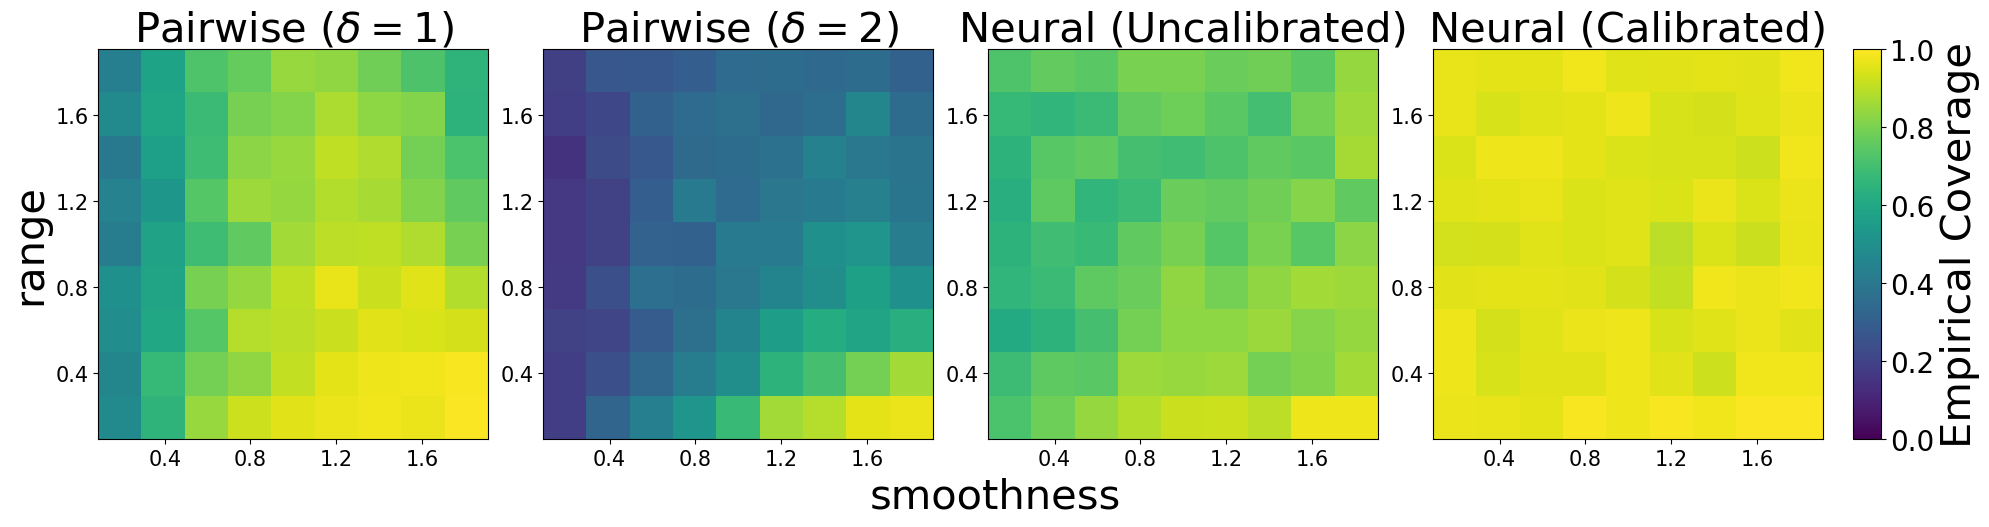

In [21]:
visualize_empirical_coverage(pwlfields1, pwlfields2, uncalibrated_fields, calibrated_fields, number_of_parameters,
                             number_of_reps, possible_ranges, possible_smooths, C, parameter_matrix)

/tmp/ipykernel_9550/1788065653.py:195: RuntimeWarning: divide by zero encountered in log
  field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
/tmp/ipykernel_9550/1788065653.py:470: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


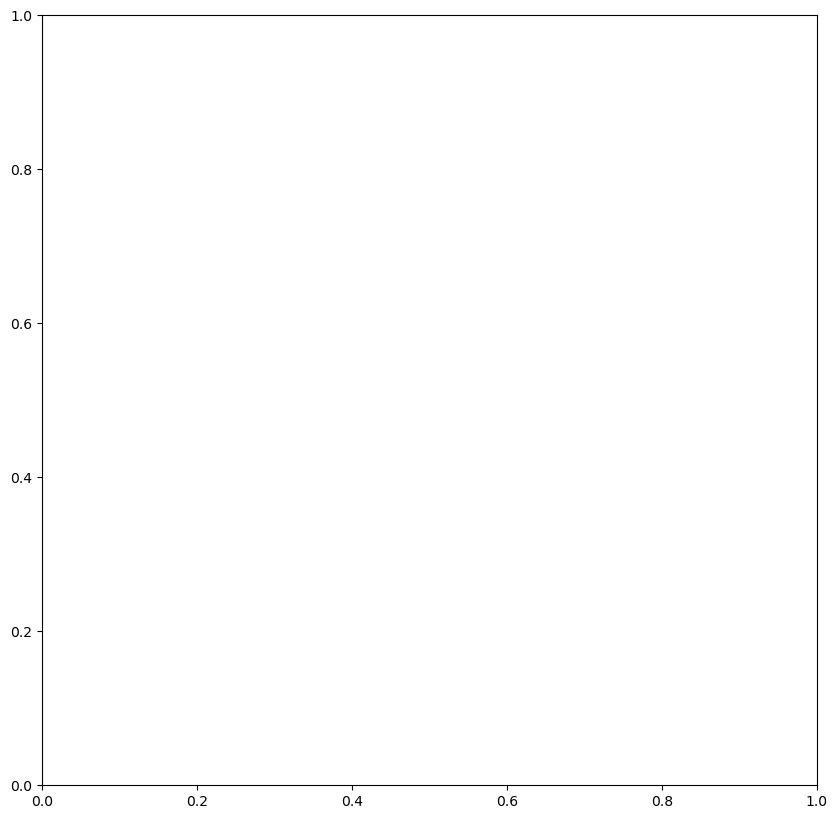

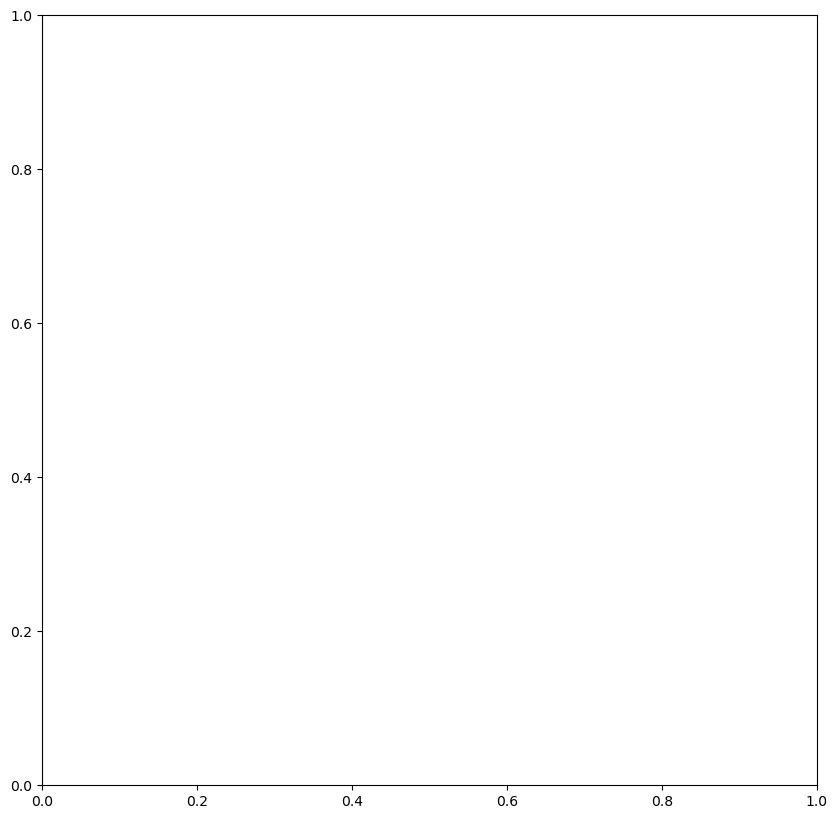

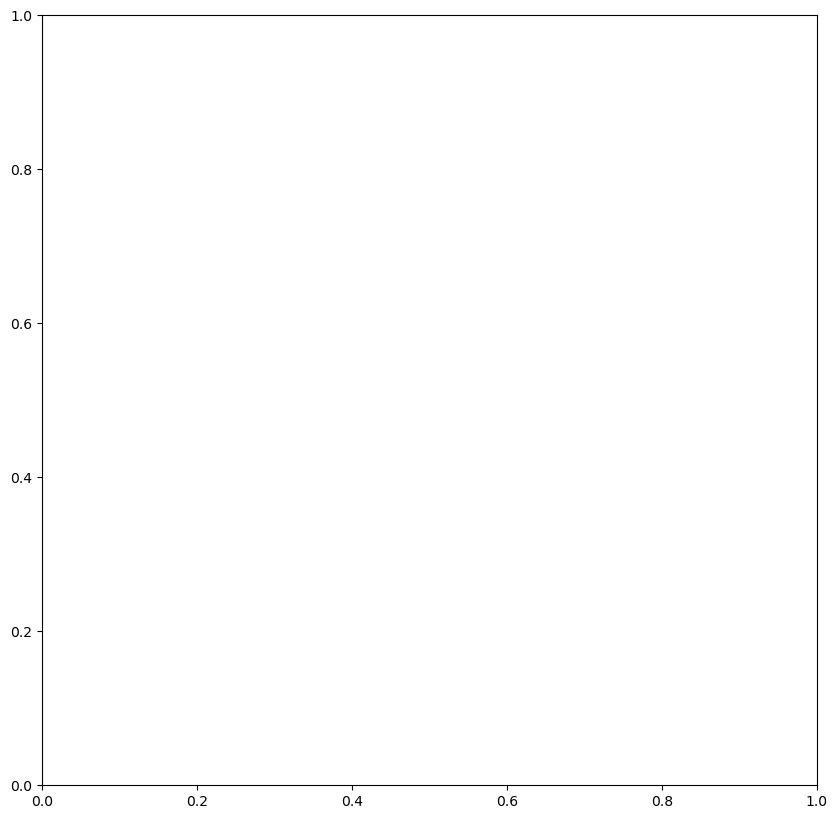

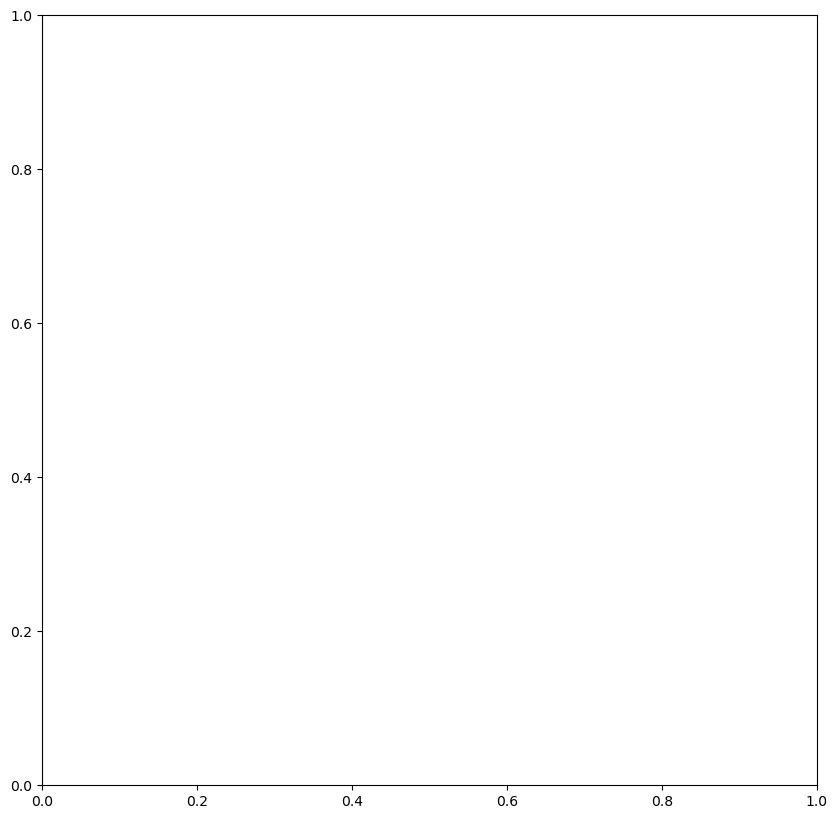

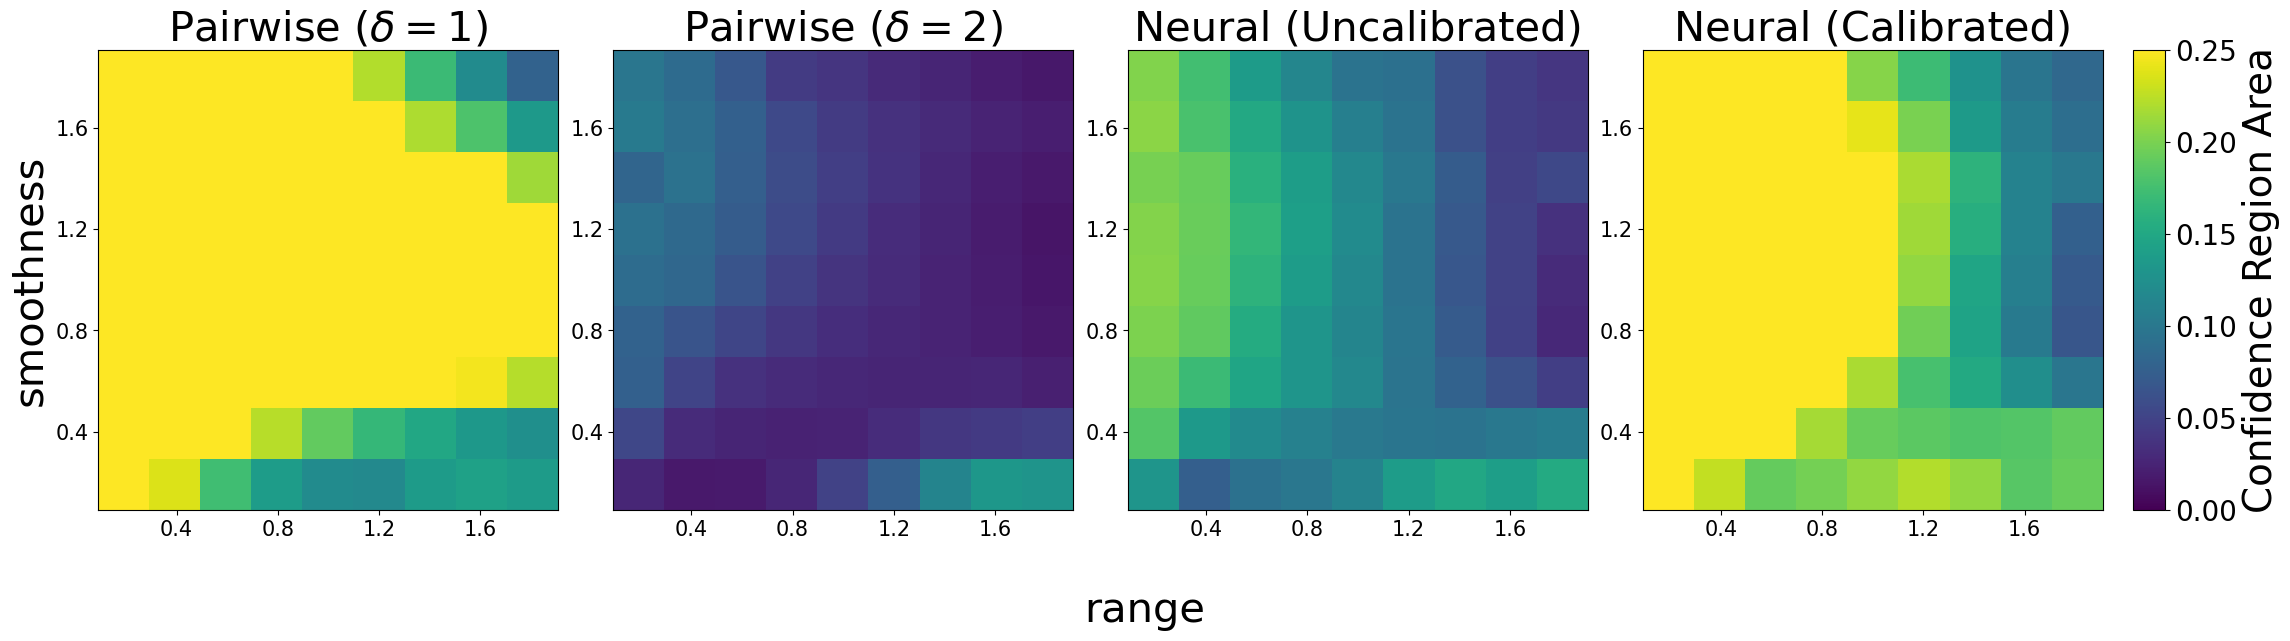

In [15]:
visualize_confidence_region_area(pwlfields1, pwlfields2, uncalibrated_fields, calibrated_fields, number_of_parameters,
                                 number_of_reps, possible_ranges, possible_smooths, C, parameter_matrix)

In [22]:
#Load data to compate unadjusted, adjusted pwl and uncalibrated and calibrated neural empirical coverage and confidence region area
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
distance_constraint = 2
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/brown_resnick"
unadjusted_pwlfields_file = (local_folder + "/evaluate_nn/produce_pairwise_likelihood_surfaces/unadjusted/data/" 
                                     + image_name + "/dist_" + str(distance_constraint) + 
                                  "/single/reps/200/pairwise_likelihood_surfaces_9_by_9_density_" + image_name
                                    + "_image_200.npy")
unadjusted_pwl_fields = np.load(unadjusted_pwlfields_file)

spectral_adjusted_pwl_fields_file = (local_folder + "/evaluate_nn/produce_pairwise_likelihood_surfaces/adjusted/data/surfaces" 
                                     + "/dist_" + str(distance_constraint) + 
                                  "/spectral/adjusted_pairwise_likelihood_surfaces_200.npy")

spectral_adjusted_pwl_fields = np.load(spectral_adjusted_pwl_fields_file)

cholesky_adjusted_pwl_fields_file = (local_folder + "/evaluate_nn/produce_pairwise_likelihood_surfaces/adjusted/data/surfaces" 
                                     + "/dist_" + str(distance_constraint) + 
                                  "/cholesky/adjusted_pairwise_likelihood_surfaces_200.npy")

cholesky_adjusted_pwl_fields = np.load(cholesky_adjusted_pwl_fields_file)

version = "final_version"
uncalibrated_fields_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + image_name
                                        + "/" + version + "/uncalibrated/single/reps/200/"
                                        "/uncalibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
uncalibrated_fields = np.load(uncalibrated_fields_file)

calibrated_fields_file = (local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + 
                                              image_name + "/" + version + "/calibrated/single/reps/200/" +
                                              "calibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
calibrated_fields = np.load(calibrated_fields_file)

number_of_parameters = 81
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_9_by_9_density_" + image_name + "_200.npy"))

possible_ranges = [round(.05*i,2) for i in range(1, 41)]
possible_ranges[39] = 1.99
possible_smooths = [round(.05*i,2) for i in range(1, 41)]
possible_smooths[39] = 1.99
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [33]:
def visualize_empirical_coverage_unadjusted_adjusted_uncalibrated_calibrated(unadjusted_pwl_fields, cholesky_pwl_fields,
                                                                             uncalibrated_fields, calibrated_fields,
                                                                             number_of_parameters, number_of_reps,
                                                                             possible_ranges, possible_smooths, C,
                                                                             parameter_matrix):
    
    ec_cholesky = compute_empirical_coverage_matrix_for_adjusted_pairwise_likelihood(cholesky_pwl_fields, number_of_parameters, 
                                                                            number_of_reps, possible_ranges, possible_smooths,
                                                                            C, parameter_matrix)
    ec_calibrated = compute_empirical_coverage_matrix_for_neural_likelihood(calibrated_fields, number_of_parameters,
                                                                            number_of_reps, possible_ranges, possible_smooths,
                                                                            C, parameter_matrix)
    ec_uncalibrated = compute_empirical_coverage_matrix_for_neural_likelihood(uncalibrated_fields, number_of_parameters,
                                                                              number_of_reps, possible_ranges, possible_smooths,
                                                                              C, parameter_matrix)
    ec_unadjusted = compute_empirical_coverage_matrix_for_pairwise_likelihood(unadjusted_pwl_fields, number_of_parameters,
                                                                              number_of_reps, possible_ranges, possible_smooths,
                                                                              C, parameter_matrix)
    
    fig = plt.figure(figsize=(20, 5.5))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,4),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    empirical_coverage_matrices = [ec_unadjusted, ec_cholesky, ec_uncalibrated, ec_calibrated]
    titles = ["Unadjusted Pairwise ($\delta = 2$)", "Adjusted Pairwise ($\delta = 2$)", "Neural (Uncalibrated)", 
              "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):

        if(i == 0):
            ax.set_ylabel("range", fontsize = 30)
        im = ax.imshow(empirical_coverage_matrices[i], interpolation='nearest', origin='lower', 
                       vmin = 0, vmax = 1, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 20)

        #annotate the three missing parameters with crosses
        if(i == 1):
            text = ax.text(1.45, 0.1, "x", ha="center", va="center", color="black", size = 54)
            text = ax.text(1.65, 0.1, "x", ha="center", va="center", color="black", size = 54)
            text = ax.text(1.85, 0.1, "x", ha="center", va="center", color="black", size = 54)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Empirical Coverage', fontsize = 30, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'smoothness', ha='center', va='center', fontsize = 30)
    #fig.text(0.1, 0.5, 'range', ha='center', va='center', rotation = 'vertical', fontsize = 40)
    plt.tight_layout()

    #plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/"
                + "visualizations/empirical_coverage_visualization_unadjusted_adjusted_uncalibrated_calibrated_200.png") 
    plt.savefig(fig_name)

def visualize_confidence_region_area_unadjusted_adjusted_uncalibrated_calibrated(unadjusted_pwl_fields, cholesky_pwl_fields,
                                                                                 uncalibrated_fields, calibrated_fields,
                                                                                 number_of_parameters, number_of_reps, 
                                                                                 possible_ranges, possible_smooths, C,
                                                                                 parameter_matrix):
    
    cr_unadjusted = compute_pairwise_likelihood_confidence_region_area_matrix(unadjusted_pwl_fields, number_of_parameters,
                                                                              number_of_reps, possible_ranges, possible_smooths,
                                                                              C, parameter_matrix)
    cr_cholesky = compute_adjusted_pairwise_likelihood_confidence_region_area_matrix(cholesky_pwl_fields, number_of_parameters,
                                                                                     number_of_reps, possible_ranges,
                                                                                     possible_smooths, C, parameter_matrix)
    cr_uncalibrated = compute_neural_likelihood_confidence_region_area_matrix(uncalibrated_fields, number_of_parameters,
                                                                              number_of_reps, possible_ranges, possible_smooths,
                                                                              C, parameter_matrix)
    cr_calibrated = compute_neural_likelihood_confidence_region_area_matrix(calibrated_fields, number_of_parameters,
                                                                            number_of_reps, possible_ranges, possible_smooths,
                                                                            C, parameter_matrix)
                                              
                                                  

    fig = plt.figure(figsize=(20, 5.5))

    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1,4),
                    axes_pad=0.55,
                    share_all=False,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.3,
                    label_mode = "all"
                    )

    cr_matrices = [cr_unadjusted, cr_cholesky, cr_uncalibrated, cr_calibrated]
    titles = ["Unadjusted Pairwise ($\delta = 2$)", "Adjusted Pairwise ($\delta = 2$)", "Neural (Uncalibrated)",
              "Neural (Calibrated)"]
    # Add data to image grid
    for i,ax in enumerate(grid):
        if(i == 0):
            ax.set_ylabel("range", fontsize = 25)
        im = ax.imshow(cr_matrices[i], interpolation='nearest', origin='lower', vmin = 0, vmax = .6, extent = [0,2,0,2])
        ax.set_xticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_yticks(fontsize=15, ticks = [(i*.44+.34) for i in range(0, 4)], labels = [round(.4*i, 1) for i in range(1, 5)])
        ax.set_title(titles[i], fontsize = 20)

        #annotate the three missing parameters with crosses
        if(i == 1):
            text = ax.text(1.45, 0.1, "x", ha="center", va="center", color="black", size = 54)
            text = ax.text(1.65, 0.1, "x", ha="center", va="center", color="black", size = 54)
            text = ax.text(1.85, 0.1, "x", ha="center", va="center", color="black", size = 54)

    # Colorbar
    cbar = ax.cax.colorbar(im)
    cbar.set_label('Confidence Region Area', fontsize = 28, rotation = 90)
    ax.cax.toggle_label(True)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.5, 0.04, 'smoothness', ha='center', va='center', fontsize = 30)

    plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_empirical_coverage_and_confidence_region_area/visualizations/" + 
                "confidence_region_area_visualization_unadjusted_adjusted_uncalibrated_calibrated_200.png") 
    plt.savefig(fig_name)

/tmp/ipykernel_9550/1223732883.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


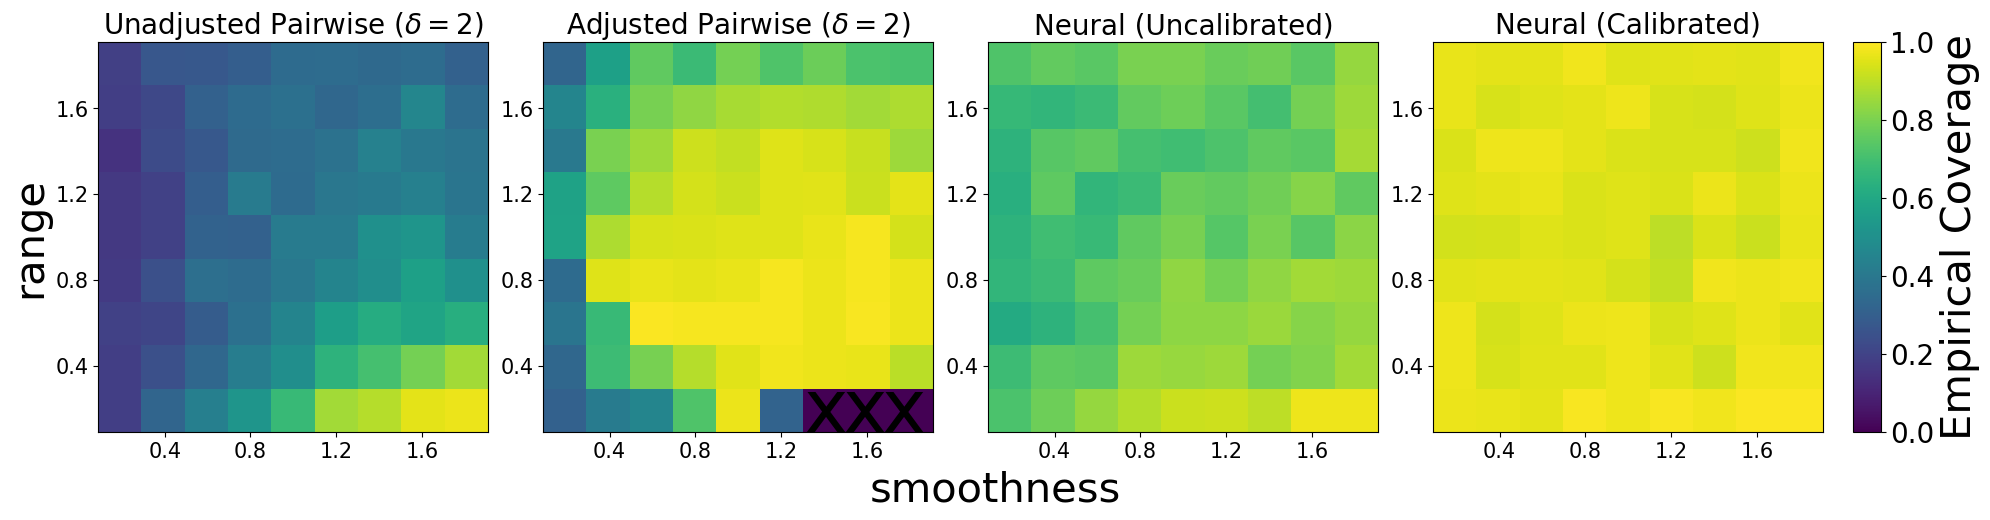

In [32]:
visualize_empirical_coverage_unadjusted_adjusted_uncalibrated_calibrated(unadjusted_pwl_fields, cholesky_adjusted_pwl_fields,
                                                                         uncalibrated_fields, calibrated_fields,
                                                                         number_of_parameters, number_of_reps,
                                                                         possible_ranges, possible_smooths, C,
                                                                         parameter_matrix)

/tmp/ipykernel_9550/4100802451.py:195: RuntimeWarning: divide by zero encountered in log
  field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
/tmp/ipykernel_9550/2911788449.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible


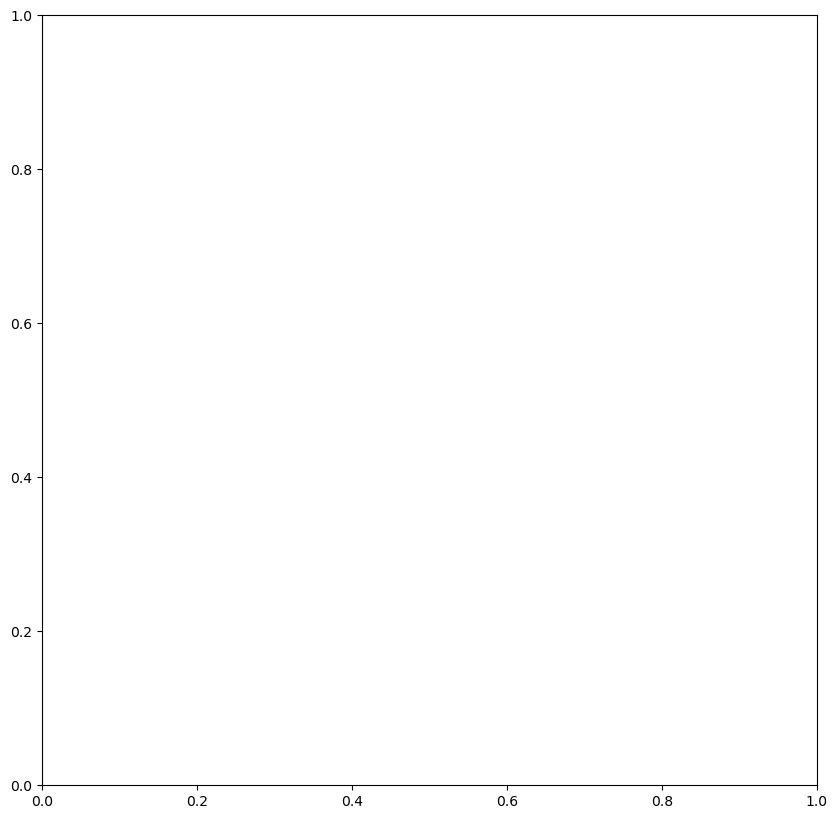

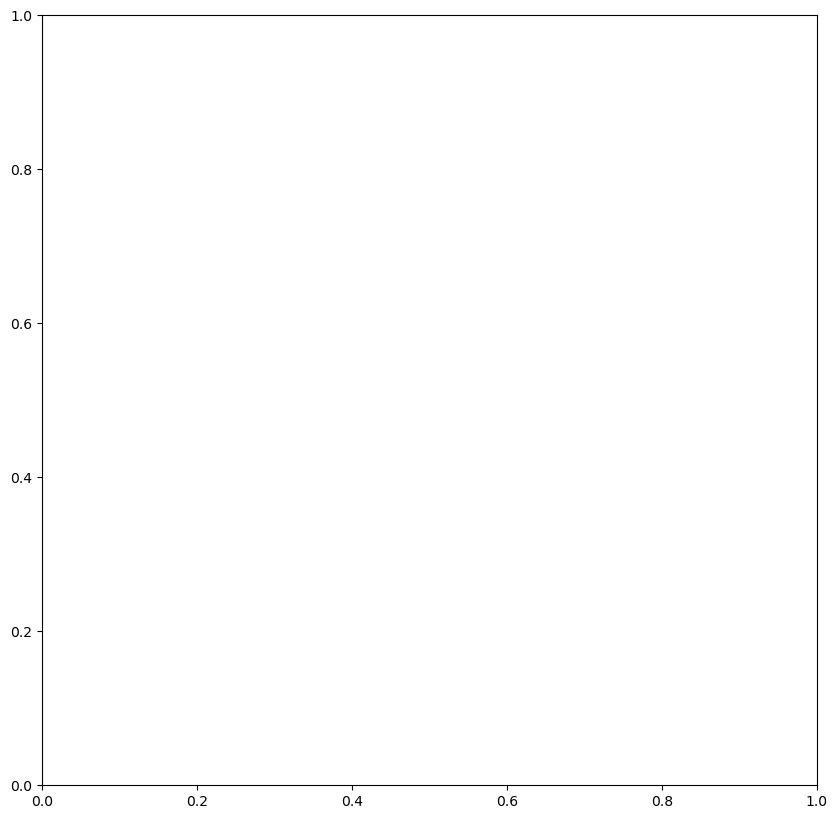

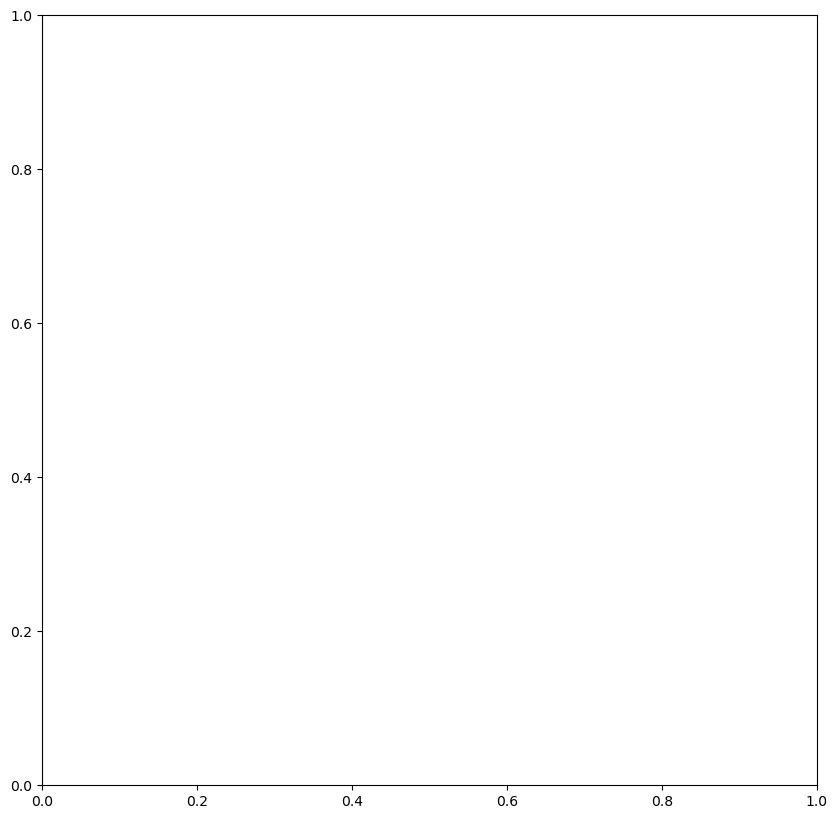

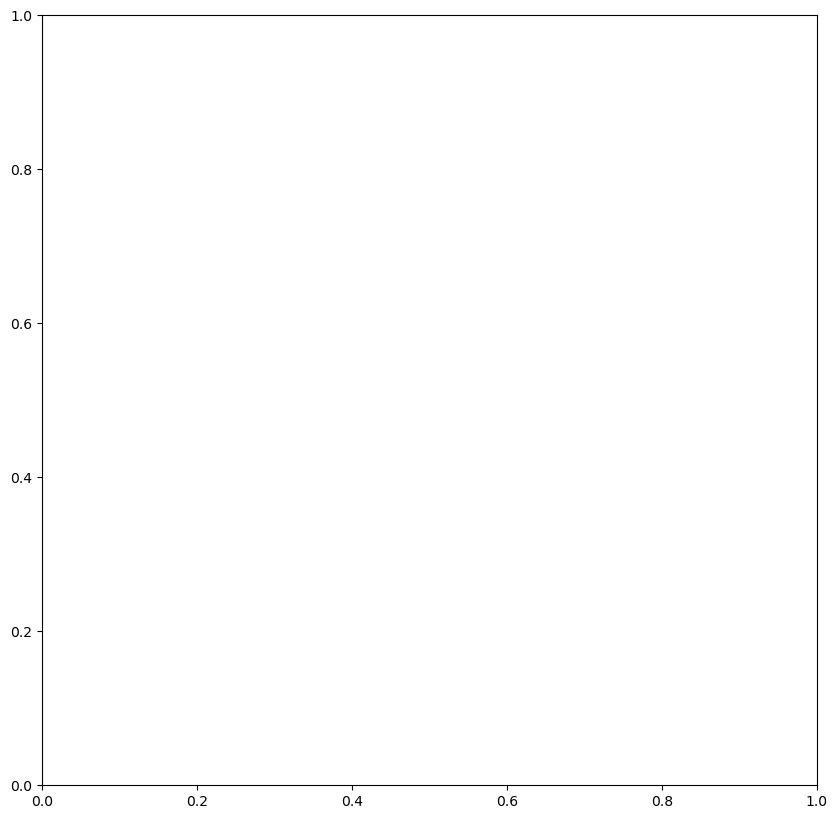

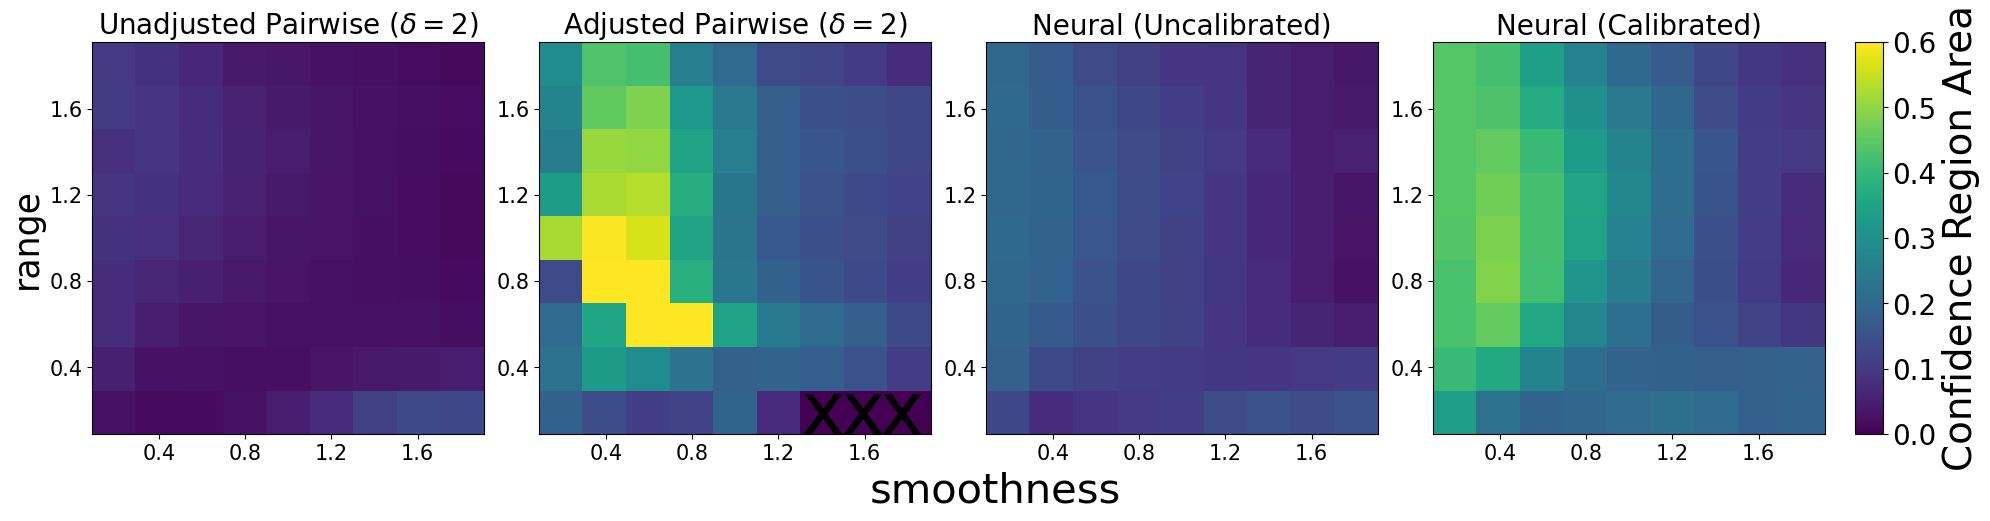

In [34]:
visualize_confidence_region_area_unadjusted_adjusted_uncalibrated_calibrated(unadjusted_pwl_fields, cholesky_adjusted_pwl_fields,
                                                                             uncalibrated_fields, calibrated_fields,
                                                                             number_of_parameters, number_of_reps, 
                                                                             possible_ranges, possible_smooths, C,
                                                                             parameter_matrix)